<a href="https://colab.research.google.com/github/vanshika1501/An-Explainable-Deep-Learning-Approach-for-Multimodal-Skin-Lesion-Classification/blob/main/Unimodal_Resnt50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**UNIMODAL IMAGE NETWORK USING RESTNET50**
 **(Creating Baseline Binary Skin Lesion Classification Model)**

*We will use only skin lesion images for binary classification- whether the skin lesion is malignant(causing cancer) or banign(non-cancerous).*

###Pre-Processing

In [ ]:
#Downloading dataset HAM10000 using kaggle -
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets list
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip /content/skin-cancer-mnist-ham10000.zip -d /content/data_folder

Streaming output truncated to the last 5000 lines.
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/data_folder/ham

In [ ]:
#Importing required libraries,modules and checking versions
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from imblearn.over_sampling import RandomOverSampler 
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import google
import glob
import itertools
import os
import pickle
import PIL
import seaborn as sns
from glob import glob
from google.colab import drive
from PIL import Image
from platform import python_version
from google.colab import drive
from keras.applications.resnet import ResNet50
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from numpy import expand_dims
from platform import python_version

%matplotlib inline

#Some other Installations-
!pip install imbalanced-learn --upgrade

# Versions
print("Version Python:",python_version())
print()   
print("Version Matplotlib:",matplotlib.__version__)
print("Version NumPy:",np.__version__)
print("Version Pandas:",pd.__version__)
print("Version PIL:",PIL.__version__)
print("Version Seaborn:",sns.__version__)
print("Version TensorFlow:",tf.__version__)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Version Python: 3.9.16

Version Matplotlib: 3.7.1
Version NumPy: 1.22.4
Version Pandas: 1.5.3
Version PIL: 8.4.0
Version Seaborn: 0.12.2
Version TensorFlow: 2.12.0


In [ ]:
import pandas as pd
metadata = pd.read_csv('/content/data_folder/HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# To check Unique values per column 
for col in metadata:
    print(metadata[col].nunique(),"The unique values present in " + col + ":",np.sort(metadata[col].unique()))
print()


7470 The unique values present in lesion_id: ['HAM_0000000' 'HAM_0000001' 'HAM_0000002' ... 'HAM_0007626' 'HAM_0007627'
 'HAM_0007628']
10015 The unique values present in image_id: ['ISIC_0024306' 'ISIC_0024307' 'ISIC_0024308' ... 'ISIC_0034318'
 'ISIC_0034319' 'ISIC_0034320']
7 The unique values present in dx: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
4 The unique values present in dx_type: ['confocal' 'consensus' 'follow_up' 'histo']
18 The unique values present in age: [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 nan]
3 The unique values present in sex: ['female' 'male' 'unknown']
15 The unique values present in localization: ['abdomen' 'acral' 'back' 'chest' 'ear' 'face' 'foot' 'genital' 'hand'
 'lower extremity' 'neck' 'scalp' 'trunk' 'unknown' 'upper extremity']



In [ ]:
# Missing values (in form of 'NA' or 'unknown') 
print("Number of 'NA' in 'age':", metadata['age'].isna().sum())
print("Number of 'unknown' in 'sex':", len(metadata[metadata['sex']=='unknown']))
print("Number of 'unknown' in 'localization':", len(metadata[metadata['localization']=='unknown']))
print()


Number of 'NA' in 'age': 57
Number of 'unknown' in 'sex': 57
Number of 'unknown' in 'localization': 234



We have 57 null values in age.Dropping these values can cause loss of metadata.
Let's replace them with mean age 

In [ ]:
#Remove rows with missing values for 'age', 'sex', and 'localization'
initial_length_metadata = len(metadata)
metadata['age'].fillna(metadata['age'].mean(), inplace=True)
metadata = metadata.drop(metadata[(metadata['localization'] == 'unknown') & (metadata['sex'] == 'unknown')].index)
#Count missing values ('NA' or 'unknown') in each column
unknown_sex_count = len(metadata[metadata['sex'] == 'unknown'])
unknown_localization_count = len(metadata[metadata['localization'] == 'unknown'])
na_age_count = metadata['age'].isna().sum()

print("Number of 'unknown' values in 'sex' column:", unknown_sex_count)
print("Number of 'unknown' values in 'localization' column:", unknown_localization_count)
print("Number of 'NA' values in 'age' column:", na_age_count)
print()

Number of 'unknown' values in 'sex' column: 10
Number of 'unknown' values in 'localization' column: 187
Number of 'NA' values in 'age' column: 0



In [ ]:
# Percentage missing (after initial drop)
print("Number of instances with multiple missing values :",sum((len(metadata[(metadata['sex'] == 'unknown') & (metadata['localization'] == 'unknown')].index),len(metadata[(metadata['sex'] == 'unknown') & (metadata['age'].isna())].index),len(metadata[(metadata['localization'] == 'unknown') & (metadata['age'].isna())].index))))
print("Percentage of missing cases for 'age':", round((metadata['age'].isna().sum()/initial_length_metadata*100),1),"%")
print("Percentage of missing cases for 'localization':", round((len(metadata[metadata['localization'] == 'unknown'])/initial_length_metadata*100),1),"%")
print("Percentage of missing cases for 'sex':", round((len(metadata[metadata['sex'] == 'unknown'])/initial_length*100),1),"%")
print()
# Drop all remaining rows containing NA's (10) and rows containing value 'unknown' (10 + 187)  
metadata = metadata.dropna()
metadata = metadata[metadata.localization != 'unknown']
metadata = metadata[metadata.sex != 'unknown']
print("Percentage of complete cases:", round((len(metadata)/initial_length*100),1),"%")


Number of instances with multiple missing values : 0
Percentage of missing cases for 'age': 0.0 %
Percentage of missing cases for 'localization': 1.9 %
Percentage of missing cases for 'sex': 0.1 %

Percentage of complete cases: 97.6 %


In [ ]:
metadata.head(974)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
989,HAM_0000613,ISIC_0031253,bkl,consensus,60.0,male,hand
990,HAM_0005101,ISIC_0024643,bkl,consensus,35.0,male,abdomen
991,HAM_0002355,ISIC_0029202,bkl,consensus,35.0,male,abdomen
992,HAM_0006912,ISIC_0026205,bkl,consensus,35.0,male,back


In [ ]:
# Creating dictionary to map lesion code with skin lesion type
lesion_classes_dict ={
    0:'akiec',
    1:'bcc',
    2:'bkl',
    3:'df',
    4:'nv',
    5:'mel',
    6:'vasc'
}
#Creating dictionary to determine full name of the skin lesion
lesions = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

#malignant skin lesion can cause cancer .
lesion_type = {
    'akiec': 'Malignant',
    'bcc': 'Malignant', 
    'bkl': 'Benign',
    'df': 'Benign',
    'mel': 'Malignant',
    'nv': 'Benign',
    'vasc': 'Benign'   
}
#Sun exposed and no-sun areas of the body
localizations = {
    'abdomen': 'No Sun',
    'acral': 'No Sun',
    'back': 'No Sun',
    'chest': 'No Sun',
    'ear': 'Sun',
    'face': 'Sun',
    'foot': 'No Sun',
    'genital': 'No Sun',
    'hand': 'Sun',
    'lower extremity': 'Sun',
    'neck': 'Sun',
    'scalp': 'Sun',
    'trunk': 'No Sun',
    'upper extremity': 'Sun'
}

In [ ]:
ham_data_folder = '../content/data_folder'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(ham_data_folder, '*', '*.jpg'))}
 

In [ ]:
#Map 'dx' codes to lesion names and create a categorical code column
metadata['dx_full'] = metadata['dx'].map(lesions.get)
metadata['dx_cat'] = pd.Categorical(metadata['dx_full']).codes
#Map 'image_id' to image file paths and map 'dx' codes to lesion types and create a categorical code column
metadata['image_path'] = metadata['image_id'].map(imageid_path_dict.get)
metadata['lesion_type'] = metadata['dx'].map(lesion_type.get)
metadata['lesion_type_cat'] = pd.Categorical(metadata['lesion_type']).codes
#Create a categorical code column for 'sex' and map 'localization' to localization groups and create a categorical code column
metadata['sex_cat'] = pd.Categorical(metadata['sex']).codes
metadata['loc_group'] = metadata['localization'].map(localizations.get)
metadata['loc_cat'] = pd.Categorical(metadata['loc_group']).codes
#Create an 'age_group' column based on age and create a categorical code column
metadata.loc[metadata['age'] >= 50, 'age_group'] = 'Older'
metadata['age_group'] = metadata['age_group'].fillna('Younger')
metadata['age_cat'] = pd.Categorical(metadata['age_group']).codes

In [ ]:
#Count the number of images per lesion and create a 'unique' column to indicate if a lesion has only one image
images_per_lesion = metadata["lesion_id"].value_counts()
def is_unique(x):
  if images_per_lesion[x] > 1:
    return False
  else:
    return True

metadata["unique"] = metadata["lesion_id"].map(is_unique)

#Rearrange the columns of metadata
metadata = metadata[['lesion_id', 'image_id', 'unique', 'dx', 'dx_full', 'dx_cat', 'lesion_type', 'lesion_type_cat', 'dx_type', 'age', 'age_group', 'age_cat', 'sex', 'sex_cat', 'localization', 'loc_group', 'loc_cat', 'image_path']]

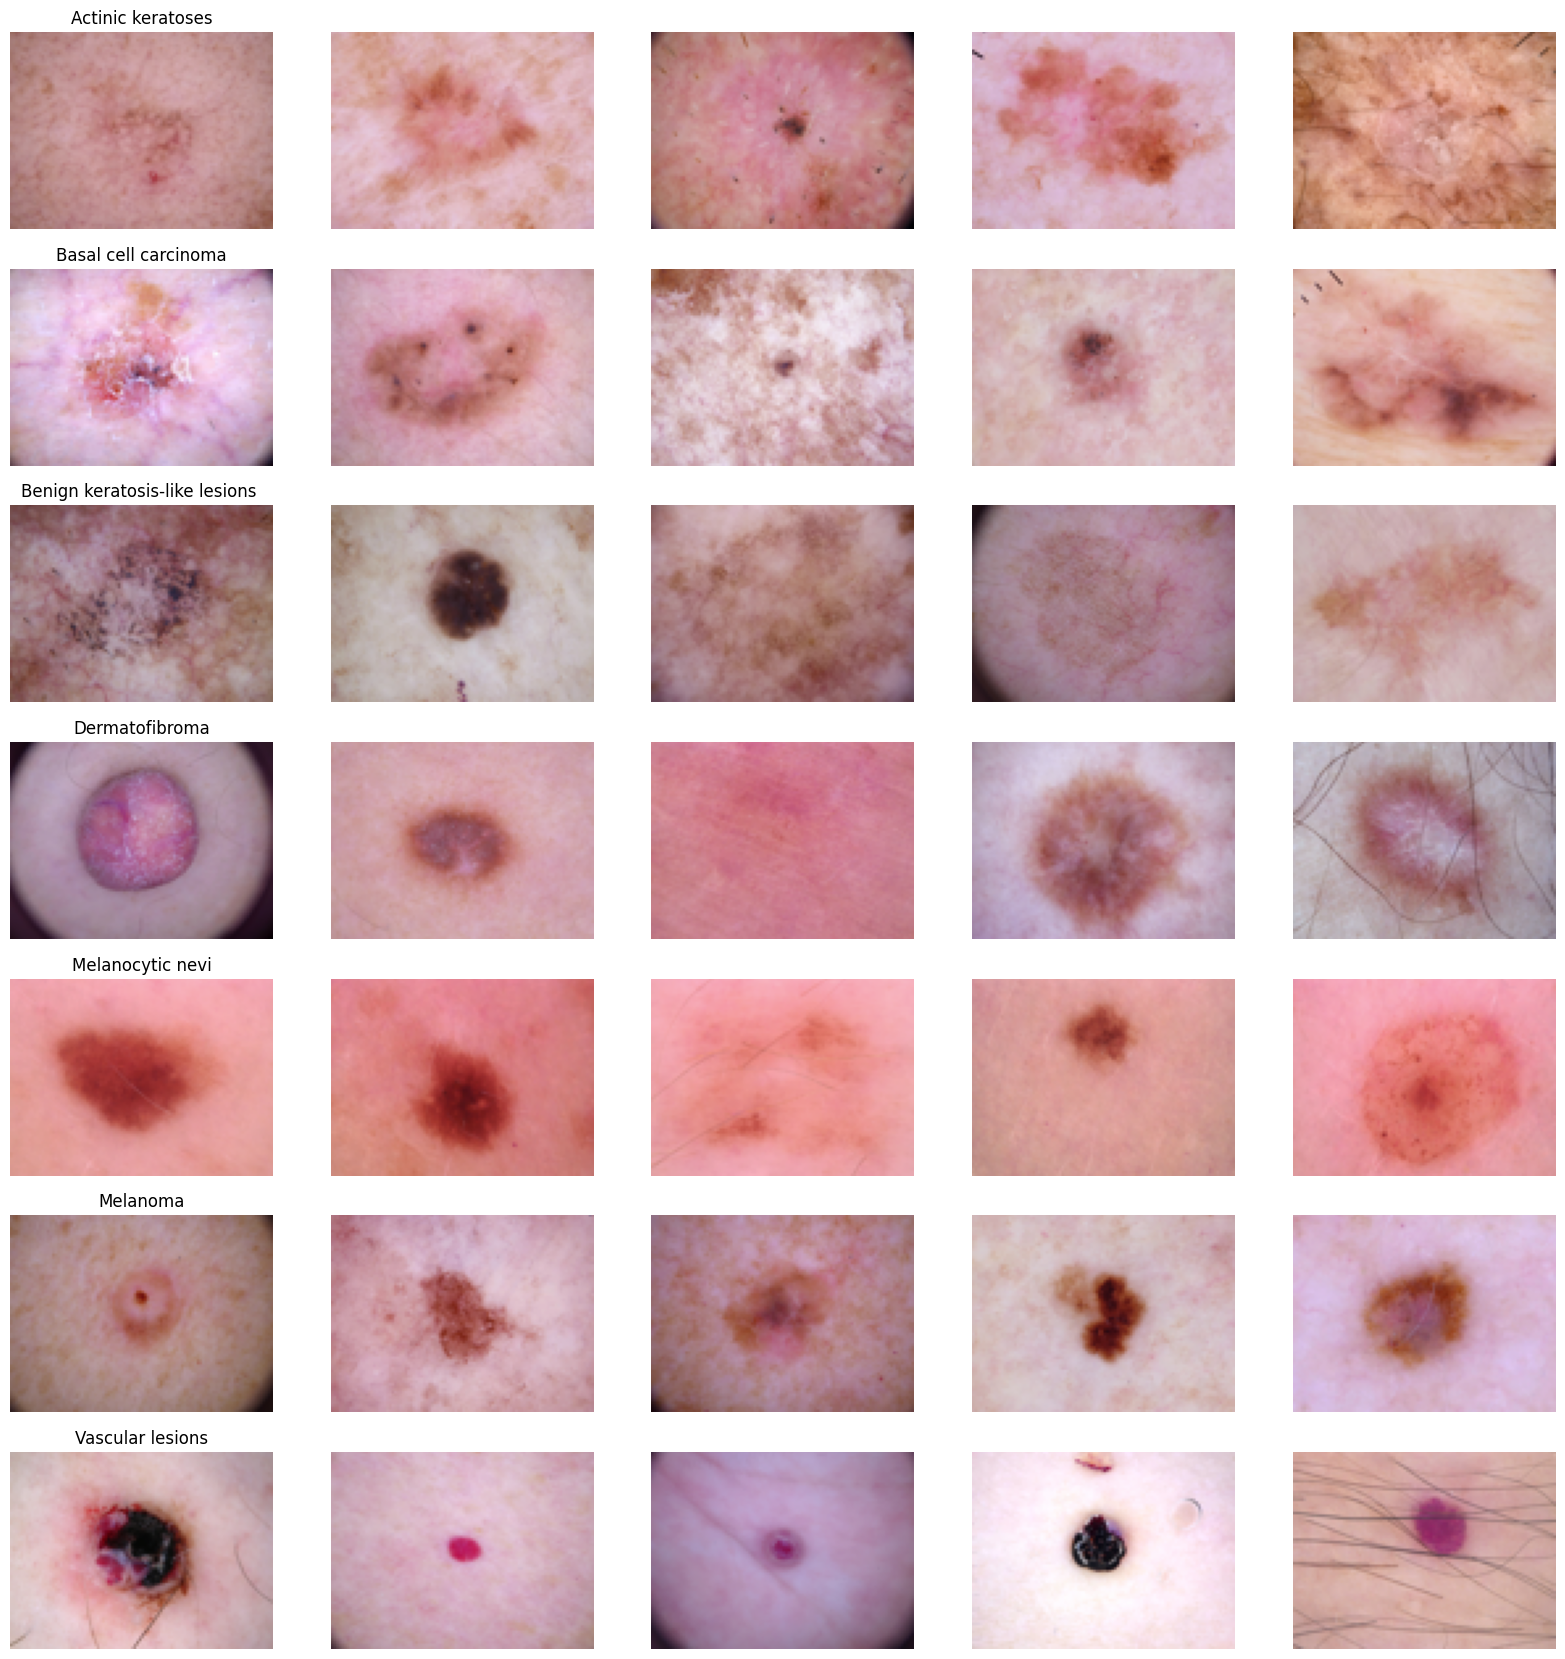

In [ ]:
#Load and resize images from 600x450 to 100x75into a numpy array and add it as a new 'image' column in metadata
metadata['image'] = metadata['image_path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
#Display samples of each lesion type in a grid of subplots
fig, m_axs = plt.subplots(7, 5, figsize=(20, 21))
for n_axs, (type_name, type_rows) in zip(m_axs, metadata.sort_values(['dx_full']).groupby('dx_full')):
  n_axs[0].set_title(type_name)
  for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(5, random_state=42).iterrows()):
    c_ax.imshow(c_row['image'])
    c_ax.axis('off')

In [ ]:
#Pickle serializes the python objects so they can be saved in a file (like byte stream)and loaded in a program whenever we want in formats 
pd.to_pickle(metadata, os.path.join('/content/data_folder', 'data.pkl'))

#Model

In [ ]:
# Set seeds
from numpy.random import seed
import tensorflow as tf
seed(42)
tf.random.set_seed(42)

In [ ]:
metadata = pd.read_pickle(os.path.join('/content/data_folder', 'data.pkl'))

In [ ]:
#Split data into training, validation and test sets with a ratio of 70:10:20.
#Validation and test sets should be from unique IDs only.
size_val_test = 0.3 * len(metadata)
val_test_ratio_from_unique = size_val_test/len(metadata[metadata['unique'] == True])
unique_ids = metadata[metadata['unique'] == True]
non_unique_ids = metadata[metadata['unique'] == False]
unique_ids_train, unique_ids_val_test = train_test_split(unique_ids, test_size=val_test_ratio_from_unique, stratify=unique_ids['lesion_type_cat'], random_state=42)
training_data = pd.concat((unique_ids_train, non_unique_ids), axis=0)
val_test_ids = pd.concat((unique_ids_val_test, non_unique_ids), axis=0)
val_test_ids = val_test_ids.drop_duplicates(subset='lesion_id', keep=False)
validation_data, test_data = train_test_split(val_test_ids, test_size=0.6667, stratify=val_test_ids['lesion_type_cat'], random_state=42)

#Oversample the training and test sets for class balancing
X_train = training_data.drop(['lesion_type_cat'], axis=1)
y_train = training_data['lesion_type_cat']

X_test = test_data.drop(['lesion_type_cat'], axis=1)
y_test = test_data['lesion_type_cat']

ros = RandomOverSampler(random_state=42)
X_resampled_train, y_resampled_train = ros.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_resampled_test, y_resampled_test = ros.fit_resample(X_test, y_test)

#Concatenate the oversampled training and test sets
training_data = pd.concat([X_resampled_train, y_resampled_train], axis=1)
test_data = pd.concat([X_resampled_test, y_resampled_test], axis=1)

#Create variables for feature (x) and target (y) training, validation and test sets
train_images = np.asarray(training_data['image'].tolist())
val_images = np.asarray(validation_data['image'].tolist())
test_images = np.asarray(test_data['image'].tolist())
train_labels = np.asarray(training_data['lesion_type_cat'].tolist())
val_labels = np.asarray(validation_data['lesion_type_cat'].tolist())
test_labels = np.asarray(test_data['lesion_type_cat'].tolist())

#One-hot encode the target variables
num_classes = len(np.sort(metadata['lesion_type_cat'].unique()))
train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [ ]:
print("Train: " + str(training_data.shape[0] / metadata.shape[0]))
print("Test: " + str(test_data.shape[0] /metadata.shape[0]))
print("Validation: " + str(validation_data.shape[0] / metadata.shape[0]))

Train: 1.065192917818033
Test: 0.35861221983420327
Validation: 0.0999897656329956


###Performing Data Augmentation

In [ ]:
data_augmentation = ImageDataGenerator(
    rotation_range = 60,
    horizontal_flip = True,  
    vertical_flip = True,  
    zoom_range = 0.2,  
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 10)

In [ ]:
# Fit data augmentation
data_augmentation.fit(train_images)

###Resnet50 model -

In [ ]:
# Model parameters
input_shape = (75, 100, 3)
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
epochs = 50
batch_size = 32

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')
history = History()

# Define model architecture
base_model = ResNet50(include_top=False, input_shape=(75,100, 3),pooling = 'avg', weights = 'imagenet');

Resnet50model_UnimodalBinary= Sequential()
Resnet50model_UnimodalBinary.add(base_model)
Resnet50model_UnimodalBinary.add(Dropout(0.2))
Resnet50model_UnimodalBinary.add(Dense(128, activation="relu"))
Resnet50model_UnimodalBinary.add(Dropout(0.2))
Resnet50model_UnimodalBinary.add(Dense(num_classes, activation = 'softmax'))
Resnet50model_UnimodalBinary.summary()

# Layers in ResNet are pretrained (ImageNet)
for layer in base_model.layers:
    layer.trainable = False

# Compile model
Resnet50model_UnimodalBinary.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy'])

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23,850,242
Trainable params: 23,797,122
Non-trainable params: 53,120
________________________________________

**Model Architecture-**

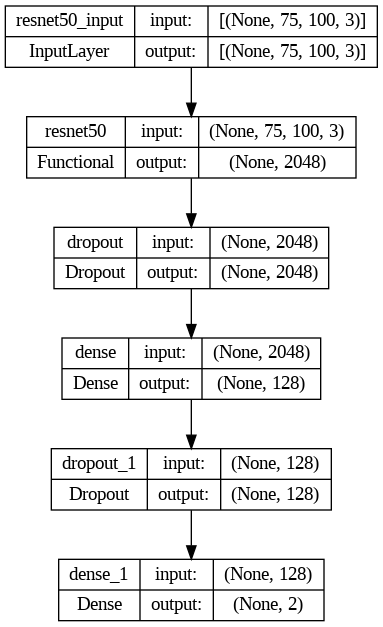

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(Resnet50model_UnimodalBinary, to_file=os.path.join('/content/data_folder', 'unimodal_architecture.png'),show_shapes = True)

**Train and save model**

In [ ]:
# Fit and save model 
Resnet50model_UnimodalBinary_history = Resnet50model_UnimodalBinary.fit(data_augmentation.flow(train_images,train_labels, batch_size=batch_size),
                        epochs = epochs, validation_data = (val_images,val_labels),
                        verbose = 1, steps_per_epoch=train_images.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor, history])


Epoch 1/50
325/325 [==============================] - 41s 90ms/step - loss: 0.5708 - accuracy: 0.7023 - val_loss: 0.2278 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 2/50
325/325 [==============================] - 28s 87ms/step - loss: 0.5218 - accuracy: 0.7280 - val_loss: 0.1835 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 3/50
325/325 [==============================] - 28s 86ms/step - loss: 0.5087 - accuracy: 0.7380 - val_loss: 0.2054 - val_accuracy: 0.8823 - lr: 0.0010
Epoch 4/50
325/325 [==============================] - 27s 84ms/step - loss: 0.5058 - accuracy: 0.7383 - val_loss: 0.1914 - val_accuracy: 0.9007 - lr: 0.0010
Epoch 5/50
325/325 [==============================] - 28s 86ms/step - loss: 0.4991 - accuracy: 0.7466 - val_loss: 0.2202 - val_accuracy: 0.8936 - lr: 0.0010
Epoch 6/50
325/325 [==============================] - 29s 89ms/step - loss: 0.4901 - accuracy: 0.7551 - val_loss: 0.1929 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 7/50
325/325 [==============================] - ETA:

In [ ]:
Resnet50model_UnimodalBinary.save(os.path.join('/content/data_folder',"Baseline_binary_model"))

#Evaluation

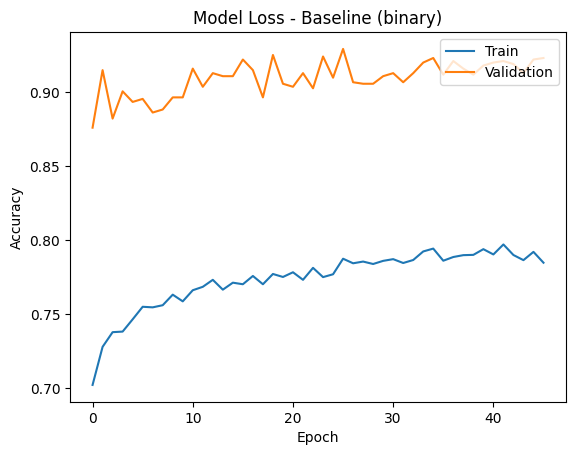

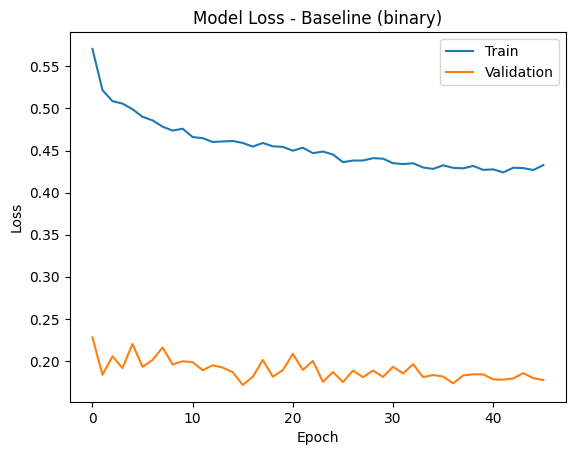

In [ ]:
# Accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss - Baseline (binary)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Accuracy - Baseline (binary).png')
#plt.savefig(os.path.join(data_folder,filename), dpi=600)
plt.show()

# Loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss - Baseline (binary)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Loss - Baseline (binary).png')
#plt.savefig(os.path.join(data_folder,filename), dpi=600)
plt.show()

Testing on some images-

In [ ]:
from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

Original Shape of image is :  (450, 600, 3)


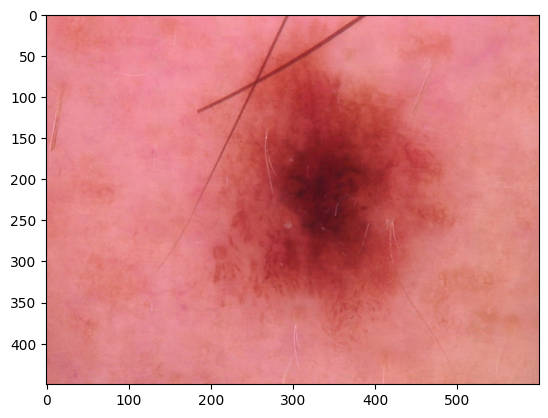

In [ ]:
test_image = np.asarray(pil_image.open('test_nv.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [ ]:
resized_image = np.asarray(pil_image.open('test_nv.jpg').resize((100,75)))
image_array = np.asarray(resized_image.tolist())
test_image2 = image_array.reshape(1,75,100,3)

New Shape of image is :  (75, 100, 3)


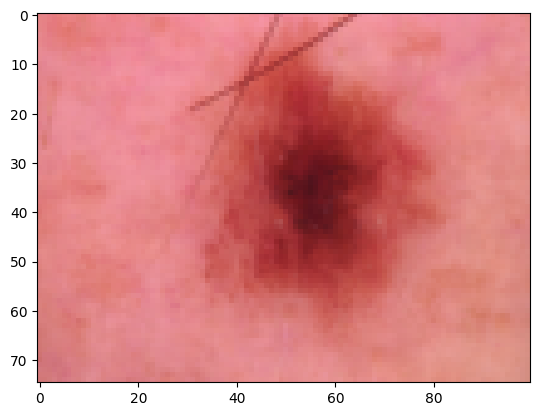

In [ ]:
plt.imshow(resized_image)
print('New Shape of image is : ',resized_image.shape)

In [ ]:
prediction_class = Resnet50model_UnimodalBinary.predict(test_image2)
prediction_class = np.argmax(prediction_class,axis=1)
prediction_class

1/1 [==============================] - 2s 2s/step


array([0])

Actual Output: Benign
Predicted Output: Benign
Non Cancerous Skin Lesion


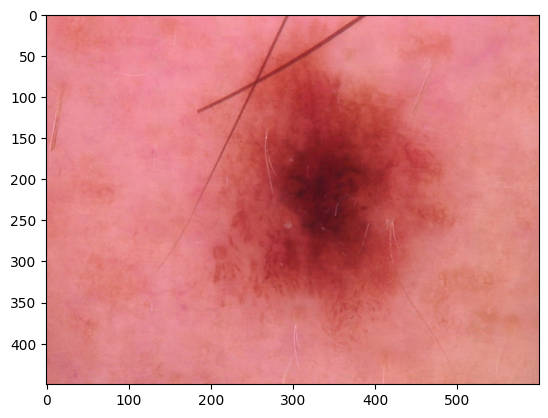

In [ ]:
df2 = pd.DataFrame(metadata)
df3=df2[df2['lesion_type_cat']==0]['lesion_type']

plt.imshow(test_image)
if(df3[0]=='Malignant'):
  x='Cancerous Skin Lesion'
else:
  x='Non Cancerous Skin Lesion'
  print('Actual Output:',lesion_type['nv'])
  print('Predicted Output:',df3[0])
  print(x)

In [ ]:
bb_y_test = np.argmax(test_labels, axis=1)
bb_y_pred_probs = Resnet50model_UnimodalBinary.predict(test_images)
bb_y_pred = np.array(list(map(lambda x: np.argmax(x), bb_y_pred_probs)))

110/110 [==============================] - 4s 26ms/step


In [ ]:
bb_loss_train, bb_accuracy_train = Resnet50model_UnimodalBinary.evaluate(train_images, train_labels, verbose=1)
bb_loss_validation, bb_accuracy_validation = Resnet50model_UnimodalBinary.evaluate(val_images, val_labels, verbose=1)
bb_loss_test, bb_accuracy_test = Resnet50model_UnimodalBinary.evaluate(test_images,test_labels, verbose=1)

110/110 [==============================] - 3s 25ms/step - loss: 0.3385 - accuracy: 0.8482


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(bb_y_test,bb_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1752
           1       0.90      0.78      0.84      1752

    accuracy                           0.85      3504
   macro avg       0.85      0.85      0.85      3504
weighted avg       0.85      0.85      0.85      3504



In [ ]:
from sklearn.metrics import precision_score

print("Precision score: {}".format(precision_score(bb_y_test,bb_y_pred)))

Precision score: 0.9034391534391535


In [ ]:
from sklearn.metrics import f1_score

print("F1 score: {}".format(f1_score(bb_y_test,bb_y_pred)))

F1 score: 0.8370098039215687


In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(bb_y_test, bb_y_pred,average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None))


0.8481735159817351


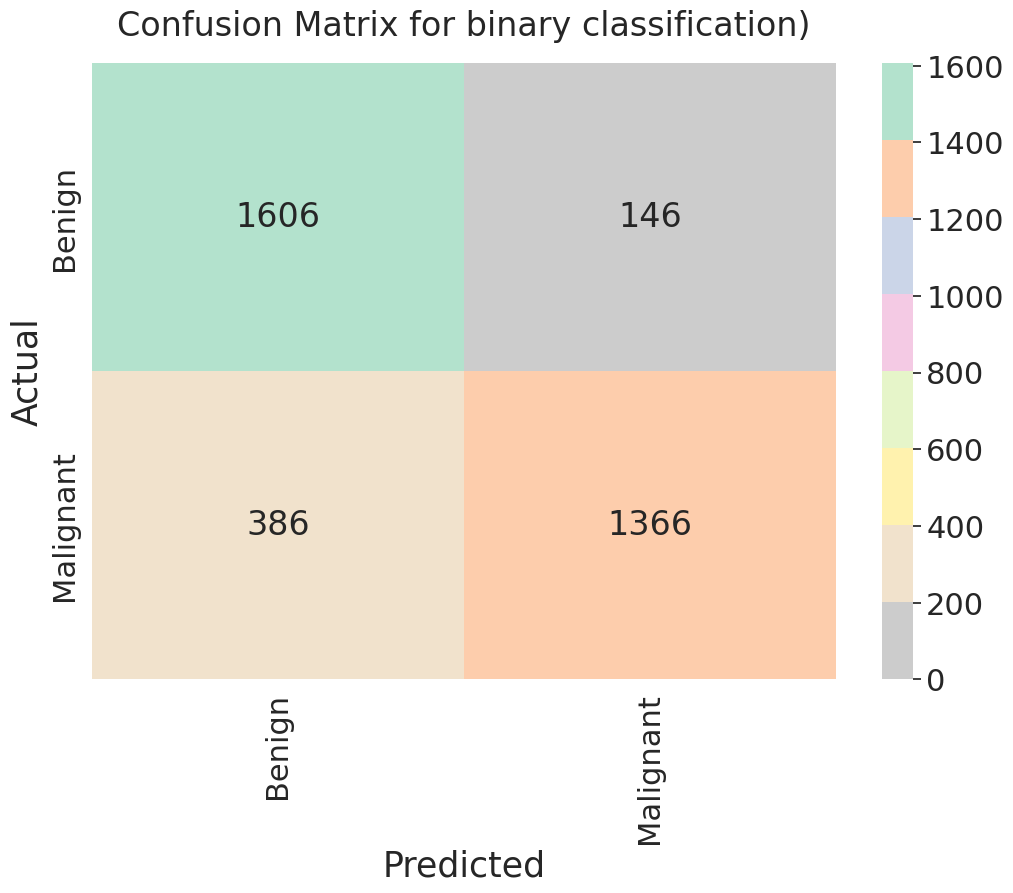

In [ ]:
lesion_types=['Benign','Malignant']
from sklearn.metrics import confusion_matrix
conf_matrix = pd.DataFrame(confusion_matrix(bb_y_test,bb_y_pred),columns = lesion_types, index = lesion_types)
plt.figure(figsize=(12,8))
sns.set(font_scale=2.0)
ax = sns.heatmap(conf_matrix, annot = True, fmt = 'g' ,vmin = 0,cmap = 'Pastel2_r')
ax.set_xlabel('Predicted',fontsize = 25)
ax.set_xticklabels(ax.get_xticklabels(),rotation =90);
ax.set_ylabel('Actual',fontsize =25)    
ax.set_title('Confusion Matrix for binary classification)',fontsize =24,pad=20);
filename = 'Confusion Matrix(binary)'
plt.savefig(os.path.join('/content/data_folder',filename), dpi=600)
plt.show()